# Measuring time delays

<a href="mailto:martin.millon@epfl.ch">Martin Millon</a>, 05.2020

PyCS3 offers two estimators, the free-knot splines and regdiff to measure a time delay. 

In [1]:
import pycs3.gen.lc_func
import pycs3.spl.topopt
import pycs3.gen.mrg
import pycs3.gen.splml
import pycs3.regdiff.multiopt
import pycs3.regdiff.rslc

In [2]:
rdbfile = "data/trialcurves.txt"

lcs = [
    pycs3.gen.lc_func.rdbimport(rdbfile, 'A', 'mag_A', 'magerr_A', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'B', 'mag_B', 'magerr_B', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'C', 'mag_C', 'magerr_C', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'D', 'mag_D', 'magerr_D', "Trial")
]
pycs3.gen.mrg.colourise(lcs) # Gives each curve a different colour.

Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/A] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/B] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/C] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/D] with 192 points imported (0 of them masked).


## Spline 
PyCS3 will model the intrinsic variability that is shared between the light curves with a single free-knot spline. It will also optmise the time delays between curves. The key parameter to control the smoothness of the fit is `knotstep`. It corresponds to the mean spacing between knots before starting the optimisation.

First, the optimising function needs to be defined. We go first for a rough estimation of the time-delay and we then refine it with the `opt_fine` function. If you shift the curves manually, and start the fit from a value that is <10 days from the true delay, running `opt_fine` only is sufficient. 

Starting ML optimization ...
Done !


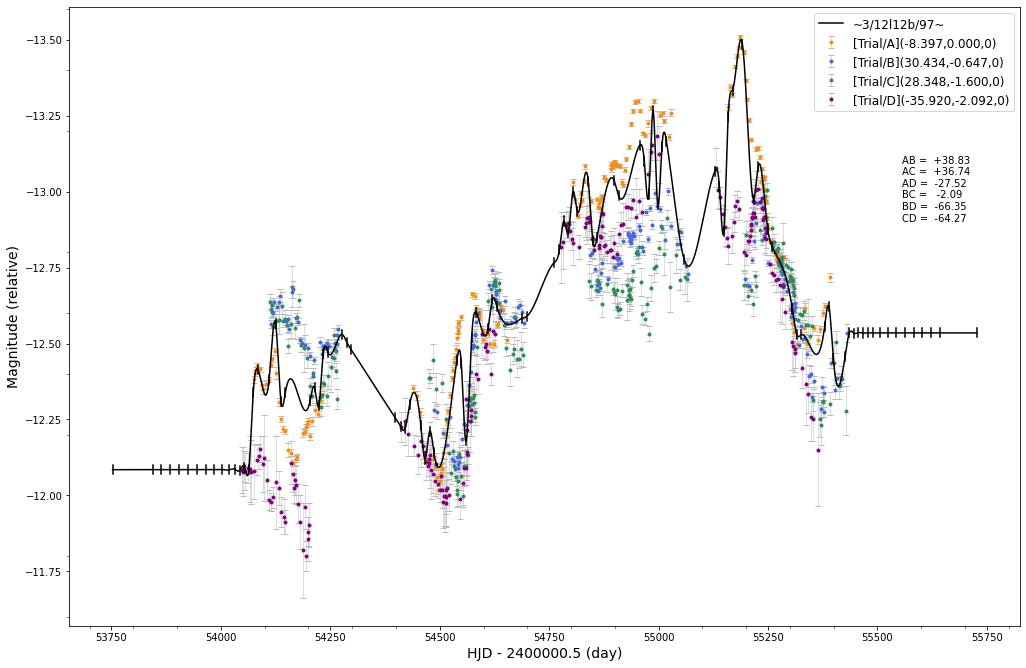

Time delays:
AB =  +38.83
AC =  +36.74
AD =  -27.52
BC =   -2.09
BD =  -66.35
CD =  -64.27


In [3]:
def spl(lcs):
    spline = pycs3.spl.topopt.opt_rough(lcs, nit=5, knotstep=30, verbose=False)
    spline = pycs3.spl.topopt.opt_fine(lcs, nit=10, knotstep=20, verbose=False)
    return spline

spline = spl(lcs)

%matplotlib inline
pycs3.gen.lc_func.display(lcs, [spline], figsize = (15,10), showdelays =True)

print ("Time delays:")
print (pycs3.gen.lc_func.getnicetimedelays(lcs, separator="\n", to_be_sorted=True))

This is a pretty poor fit... This is because the curves are affected by extrinsic variation (e.g., microlensing). We need to account for this by introducing a microlensing model. 


### Adding spline microlensing 
We can now attach a spline to each light curves to model extrinsic variability with splines. Choose a knotstep larger than the knotstep of the intrinsic spline to ensure that the microlensing model is not too degenerate with the intrinsic model. 

Starting ML optimization ...
Working on the spline ML of [Trial/A](-8.397,0.000,0)|~3/u/5~|
Working on the spline ML of [Trial/B](30.434,-0.647,0)|~3/u/5~|
Working on the spline ML of [Trial/C](28.348,-1.600,0)|~3/u/5~|
Working on the spline ML of [Trial/D](-35.920,-2.092,0)|~3/u/5~|
Done !


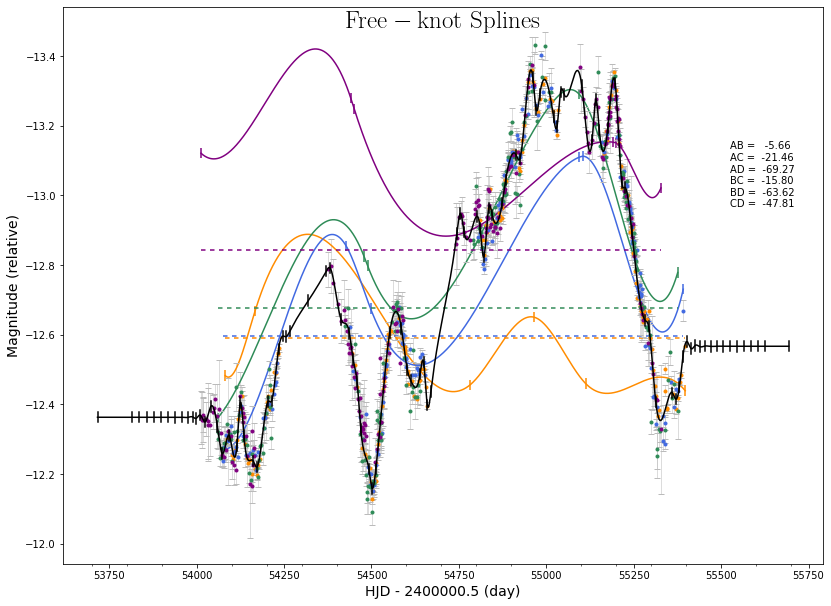

Time delays:
AB =   -5.66
AC =  -21.46
AD =  -69.27
BC =  -15.80
BD =  -63.62
CD =  -47.81


In [4]:
mlknotstep = 200

for lc in lcs : 
    pycs3.gen.splml.addtolc(lc, knotstep=mlknotstep) #we attach microlensing to the LightCurve object

spline = spl(lcs)
pycs3.gen.lc_func.display(lcs, [spline], figsize = (12,9), showdelays =True, 
                          showlegend =False, title=r"$\mathrm{Free-knot\ Splines }$")
print ("Time delays:")
print (pycs3.gen.lc_func.getnicetimedelays(lcs, separator="\n", to_be_sorted=True))

This is now much better and we recover time delays close to the correct "true" delays : $\Delta t_{AB}$ = -5 days, $\Delta t_{AC}$ = -20 days and $\Delta t_{AD}$ = -70 days 

### Adding polynomial microlensing 
PyCS3 also offer the possibility to model the extrinsic variability with polynomials. To demonstrate the flexibility of PyCS3, we will add : 
- polynomial microlensing of degree 1, to each season of the B curves
- polynomial microlensing of degree 2 on the entire monitoring campaign for the C light curve
- polynomial microlensing of degree 2 on the entire monitoring campaign for the D light curve


Starting ML optimization ...
Working on the poly ML of [Trial/B](0.000,-0.647,0)|poly/2222|
Working on the poly ML of [Trial/C](-10.000,-1.600,0)|poly/3|
Working on the poly ML of [Trial/D](-60.000,-2.092,0)|poly/4|
Done !


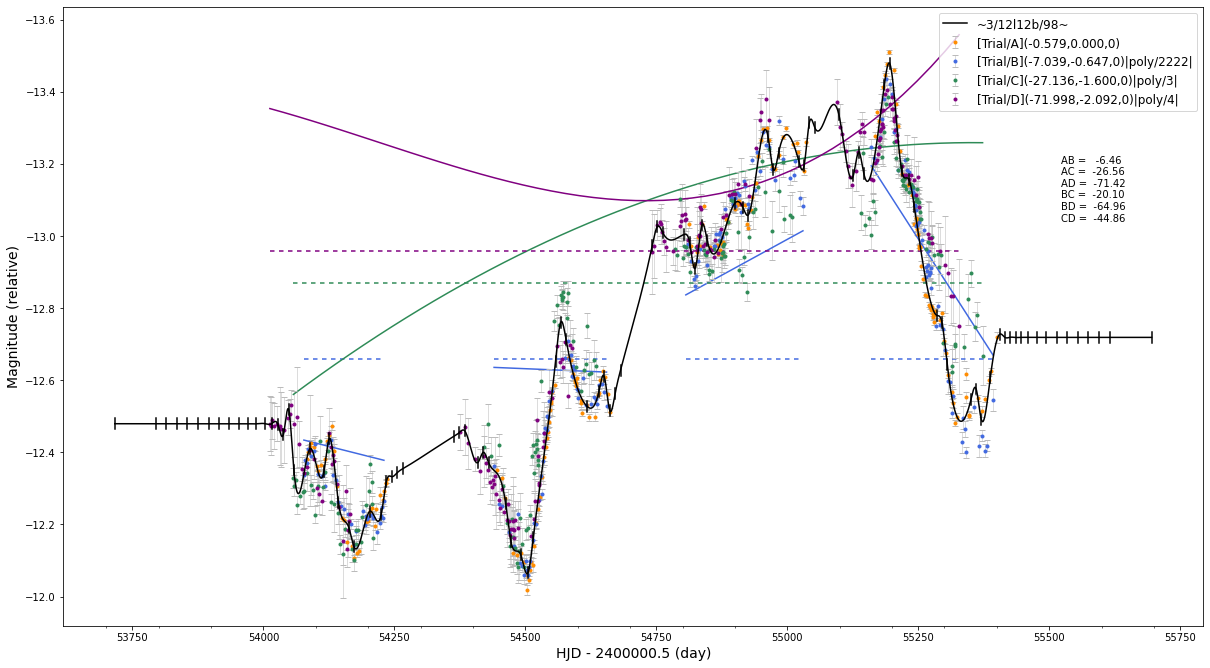

Time delays:
AB =   -6.46
AC =  -26.56
AD =  -71.42
BC =  -20.10
BD =  -64.96
CD =  -44.86


In [5]:
for lc in lcs : 
    lc.resetshifts() #We reset the time shift, magnitude shift and remove microlensing
    
pycs3.gen.lc_func.applyshifts(lcs, [0.,0.,-10.,-60.], [0.,0.,0.,0.]) # we had an initial guess of the time delay
    
#we now add polynomial microlensing to the curves
pycs3.gen.polyml.addtolc(lcs[1], nparams=2, autoseasonsgap=60.0)  # add affine microlensing to each season
pycs3.gen.polyml.addtolc(lcs[2], nparams=3, autoseasonsgap=600.0)  # add polynomial of degree 2 on the entire light curve
pycs3.gen.polyml.addtolc(lcs[3], nparams=4, autoseasonsgap=600.0)

spline = spl(lcs)
pycs3.gen.lc_func.display(lcs, [spline], figsize = (18,10), showdelays =True)
print ("Time delays:")
print (pycs3.gen.lc_func.getnicetimedelays(lcs, separator="\n", to_be_sorted=True))

## Regdiff
The second estimator of PyCS3 performs a regression with Gaussian Processes on each light curves. The regressions are then shifted in time and subtracted pair-wise. The algorithm optimizes the time-shift between the curves by minimizing the variability in the subtracted light curve. 

The most important parameter to choose is the kernel function. PyCS3 supports `matern`, `RBF`, `RatQuad` and is based on the `scikit-learn` implementation (see, scikit-learn [documentation](https://scikit-learn.org/stable/modules/gaussian_process.html) for details). A `matern` covariance kernel with $\nu =1.5$, works well in general. The `scale` and `amp` parameter are just starting points and are optimised so their initial values do not impact the fit in most of the cases. The `errscale` parameter is used to introduce an additionnal scaling factor of the photometric error bars.

In [7]:
for lc in lcs : 
    lc.resetshifts() #We reset the time shift, magnitude shift and remove microlensing
pycs3.gen.lc_func.applyshifts(lcs, [0.,0.,-10.,-60.], [0.,0.,0.,0.]) # we had an initial guess of the time delay

kwargs_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'errscale': 1., 'amp':1., 'scale':200., 
                 'verbose': True, 'method': "weights"}

myrslcs, error_fct = pycs3.regdiff.multiopt.opt_ts(lcs, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'], pow=kwargs_reg['pow'],
                           errscale=kwargs_reg['errscale'], verbose=False,
                           method="weights")
print ("Time delays:")
print (pycs3.gen.lc_func.getnicetimedelays(lcs, separator="\n", to_be_sorted=True))


Time delays:
AB =   -4.35
AC =  -20.49
AD =  -70.36
BC =  -16.14
BD =  -66.02
CD =  -49.87


And the visualization plot : 

Text(0, 0.5, '$m_{A} - m_{D}$ \n $\\mathrm{(mag)}$')

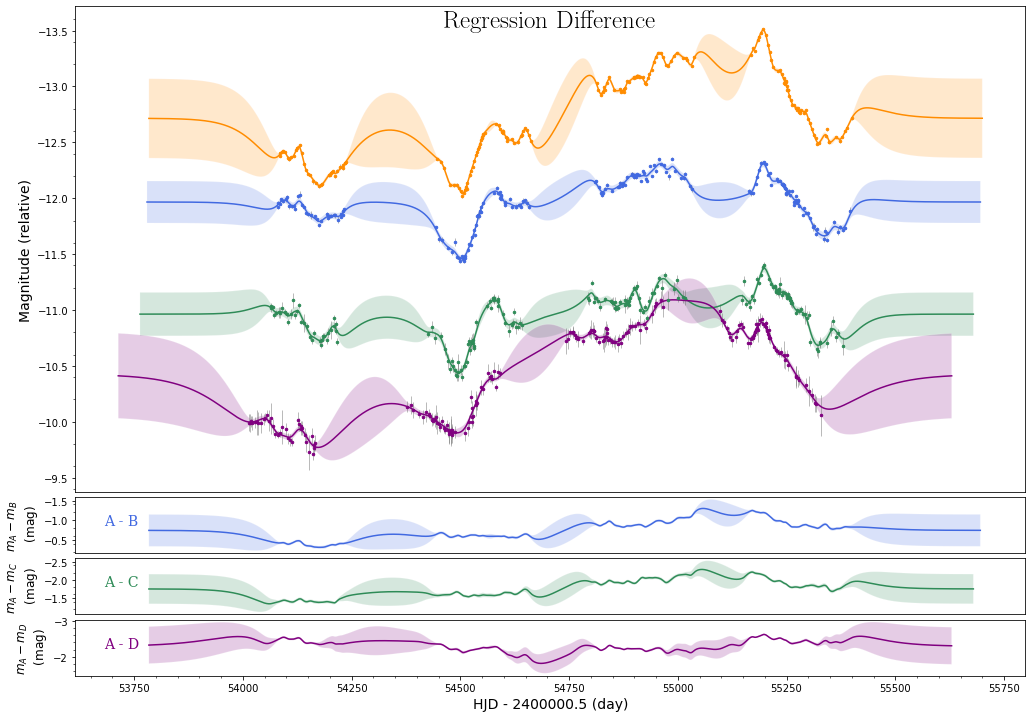

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt 

#the light curves are already shifted in time.
myrslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'],
                                     pow=kwargs_reg['pow'], amp=kwargs_reg['amp'], scale=kwargs_reg['scale'], errscale=kwargs_reg['errscale']) for l in lcs]
rslcs_residuals = [pycs3.regdiff.rslc.subtract(myrslcs[0],myrslcs[i]) for i in [1,2,3]]

#prepare the figure pannel : 
fig1 = plt.figure(figsize=(15, 10))
gs1 = gridspec.GridSpec(11, 2)
gs1.update(left=0.08, right=0.96, top=0.98, bottom=0.05, wspace=0.05, hspace=0.09)
ax1 = plt.subplot(gs1[:8, :])
ax2 = plt.subplot(gs1[8:9, :],sharex=ax1)
ax3 = plt.subplot(gs1[9:10, :],sharex=ax1)
ax4 = plt.subplot(gs1[10:11, :],sharex=ax1)

#colorize the residuals curves : 
for j,lc in enumerate(rslcs_residuals):
    lc.plotcolour = lcs[j+1].plotcolour

#prepare the legend for the difference curves
disptext = []
for j,lc in enumerate(rslcs_residuals) :
    ycoord = 0.5
    xcoord = 0.03
    kwargs = {"fontsize": 14, "color": lcs[j+1].plotcolour}
    txt = "A - %s"%lcs[j+1].object
    disptext.append((xcoord, ycoord, txt, kwargs))

#plot the curves, regression, and difference curves : 
pycs3.gen.lc_func.display(lcs, myrslcs, showdelays=False, showlegend=False,
                    title=r"$\mathrm{Regression\ Difference }$", filename = "screen", ax=ax1,  style="cosmograil_dr1")
pycs3.gen.lc_func.display([],[rslcs_residuals[0]], showdelays=False, showlegend=False, filename = "screen", ax=ax2, style="cosmograil_dr1", text = [disptext[0]])
pycs3.gen.lc_func.display([],[rslcs_residuals[1]], showdelays=False, showlegend=False, filename = "screen", ax=ax3, style="cosmograil_dr1", text = [disptext[1]])
pycs3.gen.lc_func.display([],[rslcs_residuals[2]], showdelays=False, showlegend=False, filename = "screen", ax=ax4, style="cosmograil_dr1", text = [disptext[2]])

#adjust the axis
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel('$m_{%s} - m_{%s}$ \n $\mathrm{(mag)}$'%(lcs[0].object[0], lcs[1].object[-1]), fontsize = 12)
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel('$m_{%s} - m_{%s}$ \n $\mathrm{(mag)}$'%(lcs[0].object[0], lcs[2].object[-1]), fontsize = 12)
ax4.set_ylabel("Regression Difference \n Residuals (mag)", fontsize = 9)
ax4.set_ylabel('$m_{%s} - m_{%s}$ \n $\mathrm{(mag)}$'%(lcs[0].object[0], lcs[3].object[-1]), fontsize = 12)